In [1]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch
from torch import nn
from torch import optim

import math

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm as tqdm

In [2]:
from multiprocessing import Pool

In [3]:
# Для Colaboratory
# !rm utils.py
# !wget https://raw.githubusercontent.com/Intelligent-Systems-Phystech/model_selection/master/Grabovoy/practice/utils.py

In [4]:
##########################################
# https://github.com/mariogeiger/hessian #
##########################################
#                                        #
# Данные функции были взяты из интернета #
#                                        #
##########################################

from utils import gradient, jacobian, hessian

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Настройки Matplotlib

In [6]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = 36
plt.rcParams['ytick.labelsize'] = 36
plt.rcParams['legend.fontsize'] = 36
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=36
plt.rcParams['figure.figsize'] = (16.0, 8.0)
plt.rcParams['font.size'] = 24

# Эксперимент

В эксперименте была рассмотрена простая синтетическая выборка.
$$\mathbf{x} \sim \mathcal{N}\left(\textbf{0}, \mathbf{I}\right), \textbf{w} \sim \mathcal{N}\left(\textbf{0}, \mathbf{I}\right), y \sim \mathcal{N}\left(\textbf{w}^{\mathsf{T}}\textbf{x}, \beta\mathbf{I}\right)$$

In [81]:
m = 128
n = 20

w = np.random.randn(n)

X_train = np.random.randn(m, n)
Y_train = (X_train@w + 0.001*np.random.randn(m)).reshape([-1, 1])

X_test = np.random.randn(m, n)
Y_test = (X_test@w+ 0.001*np.random.randn(m)).reshape([-1, 1])

X_valid = np.random.randn(m, n)
Y_valid = (X_test@w+ 0.001*np.random.randn(m)).reshape([-1, 1])

In [82]:
train_data = TensorDataset(torch.Tensor(X_train).to(device), torch.Tensor(Y_train).to(device))
valid_data = TensorDataset(torch.Tensor(X_test).to(device), torch.Tensor(Y_test).to(device))
test_data = TensorDataset(torch.Tensor(X_test).to(device), torch.Tensor(Y_test).to(device))

In [83]:
X_ts, Y_ts = test_data[:]

X_tr, Y_tr = train_data[:]

X_valid, Y_valid = valid_data[:]

В качестве модели рассматривалась полносвязная нейросеть с разным количеством нейронов на скрытом слое.

In [84]:
class Neural(nn.Module):
    def __init__(self, input_dim=10, hidden_dim=3, output_dim=1, device='cpu'):
        """
        """
        super(Neural, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.device = device

        self.body = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.LeakyReLU(),
        )
        
        self.head = nn.Linear(self.hidden_dim, self.output_dim)
        
        list_of_w = []
        for w in self.parameters():
            list_of_w.append(w.data.view(-1))
        self.D = len(torch.cat(list_of_w).view(-1))

        list_of_h = []
        for w in self.parameters():
            list_of_h.append(torch.ones_like(w.data, requires_grad=True))
        
        self.list_of_h = list_of_h
        
        self.to(device)

        
    def predict(self, input):
        """
        Args:
            input: Tensor(batch_size x input_dim) --- the matrix of input data
            
        Returns:
            Tensor(batch_size x output_dim) --- the matrix of output data
        
        """
        out = input
        out = self.body(out)
        return self.head(out)
    
    def log_prior_w(self, w, h):
        """
        """
        w = w.view(-1)
        h = h.view(-1)
        return -0.5*torch.dot(w*(h**2), w)
      
    def log_priot_all(self):
        temp = 0
        i_temp = 0
        for w, h in zip(self.parameters(), self.list_of_h):
            temp += self.log_prior_w(w, h)
        return temp
     
    def loglikelihood(self, batch_x, batch_y):
        """
        """
        beta = 1
        return -0.5*beta*torch.mean((self.predict(batch_x) - batch_y)**2)
    
    def margin_log_likelihood(self, batch_x, batch_y):
        """
        """
        temp = self.log_priot_all() + self.loglikelihood(batch_x, batch_y)
        return temp
    
    def loss(self, batch_x, batch_y):
        out = self.predict(batch_x)
        return torch.mean((out - batch_y)**2)
    
    def random_h_init(self):
        for h in self.list_of_h:
            h.data = torch.rand_like(h.data)

    def h_zero_grad(self):
        for h in self.list_of_h:
            h.grad.zero_()

    def h_set_grad(self, grad):
        bias = 0
        for h in self.list_of_h:
            h_size = torch.tensor(h.size()).prod()
            h.grad = grad[bias:bias+h_size].view_as(h)
            bias+=h_size
            
    def h_set_data(self, data):
        bias = 0
        for h in self.list_of_h:
            h_size = torch.tensor(h.size()).prod()
            h.data = data[bias:bias+h_size].view_as(h)
            if h.grad is not None:
                h.grad.zero_()
            bias+=h_size

# Random Search

In [104]:
def h_to_numpy(model):
    List_of_h = []
    for h in model.list_of_h:
        List_of_h.append(h.data.cpu().numpy().reshape(-1))

    return np.hstack(List_of_h)

def get_Q_theta_star_h(model, h):
    """
    Args:
        h, tensor --- model HyperParameters
    """
    model.__init__(model.input_dim, model.hidden_dim, model.output_dim, model.device)
    model.h_set_data(h)
    
    optimazer = optim.Adam(model.parameters(), lr=0.01)

    List_of_step = []

    for ep in range(200):
        generator = DataLoader(train_data, batch_size=64, shuffle=True)
        for batch_x, batch_y in generator:
            model.zero_grad()
            loss = -model.margin_log_likelihood(batch_x, batch_y)
            loss.backward()
            optimazer.step()
            
    return h_to_numpy(model), model.loss(X_valid, Y_valid).item()
    

In [92]:
def random_search(number_of_search = 10, model = Neural(), progress = list):
    List_of_h = []
    List_of_loss = []

    for _ in progress(range(number_of_search)):
        h = torch.rand(model.D)
        h, Q_loss = get_Q_theta_star_h(model, h)

        List_of_h.append(h)
        List_of_loss.append(Q_loss)

    return np.array(List_of_h), np.array(List_of_loss)

In [93]:
model = Neural(input_dim=n, output_dim=1, hidden_dim=1)

In [94]:
%%time
List_of_h_random, List_of_loss_random = random_search(100, model, progress=tqdm)

100%|██████████| 100/100 [01:14<00:00,  1.47it/s]

CPU times: user 1min 11s, sys: 974 ms, total: 1min 12s
Wall time: 1min 14s


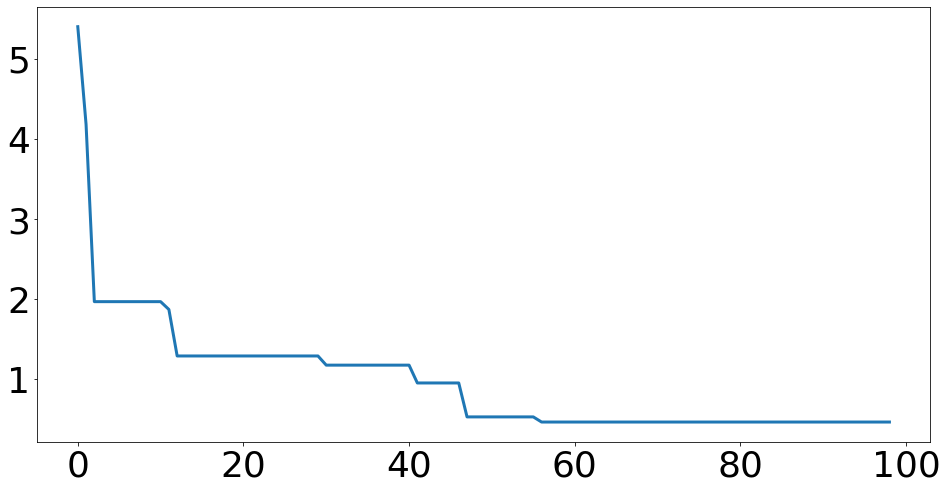

In [99]:
_ = plt.plot([np.min(List_of_loss_random[:i]) for i in range(1, len(List_of_loss_random))])

In [96]:
idx = np.argmin(List_of_loss_random)
best_h_random = List_of_h_random[idx]
best_h_random

array([0.42681253, 0.41607547, 0.86045116, 0.6213664 , 0.6790934 ,
       0.17669857, 0.2595083 , 0.44574124, 0.01503664, 0.74890447,
       0.96852416, 0.813098  , 0.22771543, 0.31492287, 0.29373688,
       0.01012194, 0.26180547, 0.41208   , 0.15358824, 0.57926315,
       0.2458548 , 0.24704957, 0.05383855], dtype=float32)

In [97]:
best_loss_random = List_of_loss_random[idx]
best_loss_random

0.4663117229938507

# Гаусовский процесс

In [105]:
import numpy as np
from pyGPGO.covfunc import squaredExponential
from pyGPGO.acquisition import Acquisition
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.GPGO import GPGO
from pyGPGO.covfunc import matern32

In [110]:
model = Neural(input_dim=n, output_dim=1, hidden_dim=1)
D = model.D

param_dict = dict()

for i in range(D):
    param_dict['h'+str(i)] = ('cont', [0, 1])

In [111]:
param_dict

{'h0': ('cont', [0, 1]),
 'h1': ('cont', [0, 1]),
 'h2': ('cont', [0, 1]),
 'h3': ('cont', [0, 1]),
 'h4': ('cont', [0, 1]),
 'h5': ('cont', [0, 1]),
 'h6': ('cont', [0, 1]),
 'h7': ('cont', [0, 1]),
 'h8': ('cont', [0, 1]),
 'h9': ('cont', [0, 1]),
 'h10': ('cont', [0, 1]),
 'h11': ('cont', [0, 1]),
 'h12': ('cont', [0, 1]),
 'h13': ('cont', [0, 1]),
 'h14': ('cont', [0, 1]),
 'h15': ('cont', [0, 1]),
 'h16': ('cont', [0, 1]),
 'h17': ('cont', [0, 1]),
 'h18': ('cont', [0, 1]),
 'h19': ('cont', [0, 1]),
 'h20': ('cont', [0, 1]),
 'h21': ('cont', [0, 1]),
 'h22': ('cont', [0, 1])}

In [112]:
%%time

def f(**argv):
    x = []
    for par in argv:
        x.append(argv[par])
    if not torch.is_tensor(x):
        x = torch.tensor(x)
# так как максимизирует библиотека возьмем ошибку со знаком минус
    return -get_Q_theta_star_h(model, x)[1]


sexp = matern32()
gp = GaussianProcess(sexp, optimize=True, usegrads=True)
acq = Acquisition(mode='ExpectedImprovement')

np.random.seed(23)
gpgo = GPGO(gp, acq, f, param_dict)
gpgo.run(max_iter=50)

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.51729788 0.9469626  0.76545976 0.28239584 0.22104536 0.68622209
 0.1671392  0.39244247 0.61805235 0.41193009 0.00246488 0.88403218
 0.88494754 0.30040969 0.58958187 0.97842692 0.84509382 0.06507544
 0.29474446 0.28793444 0.82246634 0.62618304 0.11047771]. 	  -2.6982526779174805 	 -1.7299144268035889
init   	 [5.28811169e-04 9.42166233e-01 1.41500758e-01 4.21596526e-01
 3.46489440e-01 8.69785084e-01 4.28601812e-01 8.28751484e-01
 7.17851838e-01 1.19226694e-01 5.96384173e-01 1.29756298e-01
 7.75340917e-02 8.31205256e-01 4.64385615e-01 1.62012479e-01
 5.47975292e-01 5.88485822e-01 7.73613169e-01 6.55845458e-01
 5.57706759e-01 1.78247267e-01 2.40583531e-01]. 	  -1.7299144268035889 	 -1.7299144268035889
init   	 [0.50605463 0.3967457  0.48305519 0.95573984 0.90160219 0.50575932
 0.82070149 0.82771593 0.23183335 0.07905549 0.46576293 0.87897581
 0.14750306 0.23125131 0.91794581 0.12906353 0.91640772 0.23479755
 0.61598677 

48     	 [1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1.]. 	  -6.553631782531738 	 -0.7175102233886719
49     	 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
 -1.38777878e-17  0.00000000e+00  0.00000000e+00]. 	  -1.0730704069137573 	 -0.7175102233886719
50     	 [1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0.]. 	  -2.5914762020111084 	 -0.7175102233886719
CPU times: user 31min 54s, sys: 1min 59s, total: 33min 54s
Wall time: 21min 10s


In [113]:
List_of_loss_gaus = -1*np.array(gpgo.history)

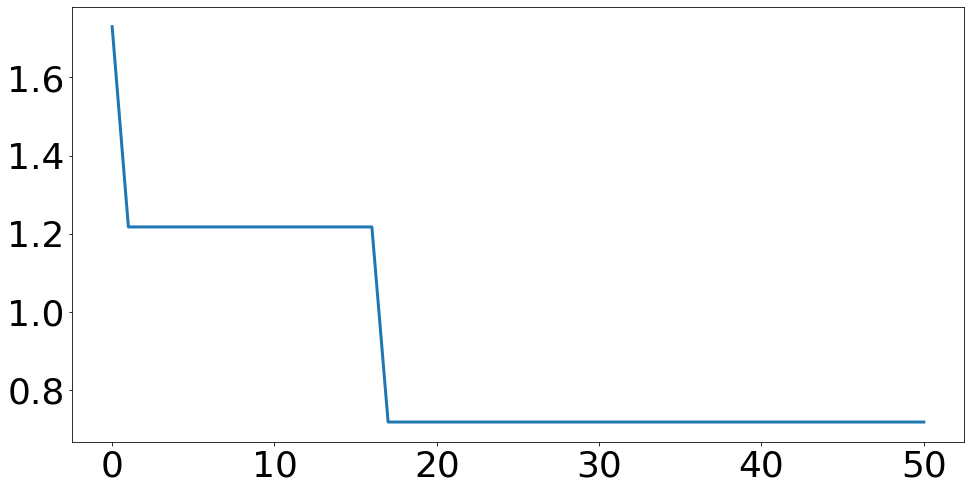

In [114]:
_ = plt.plot(List_of_loss_gaus)

In [115]:
best_h_gaus, best_loss_gaus = gpgo.getResult()[0], -gpgo.getResult()[1]
List_of_h = []
for key in best_h_gaus:
    List_of_h.append(best_h_gaus[key])
    
best_h_gaus = np.array(List_of_h)
best_h_gaus

array([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 0., 0., 0.])

In [116]:
best_loss_gaus

0.7175102233886719

Почему-то гаусовский процесс ищет решение на границе множества

# HOAG

In [183]:
model = Neural(input_dim=n, output_dim=1, hidden_dim=1)
model.random_h_init()

optimazer_theta = optim.Adam(model.parameters(), lr=0.01)
optimazer_h = optim.SGD(model.list_of_h, lr=0.01)

List_of_h = []
List_of_loss = []

for epoch in tqdm(range(200)):
    for ep in range(200):
        generator = DataLoader(train_data, batch_size=64, shuffle=True)
        for batch_x, batch_y in generator:
            model.zero_grad()
            loss = -model.margin_log_likelihood(batch_x, batch_y)
            loss.backward()
            optimazer_theta.step()
    
    model.zero_grad()
    model.h_zero_grad()
    hess = hessian(-model.margin_log_likelihood(X_valid, Y_valid), model.parameters())
    model.h_zero_grad()
    model.zero_grad()
    grad = gradient(model.loss(X_valid, Y_valid), model.parameters())

    lambd = torch.inverse(hess)@grad

    model.h_zero_grad()
    model.zero_grad()
    grad = gradient(-model.margin_log_likelihood(X_valid, Y_valid), model.parameters(), create_graph=True)

    mat = torch.cat([gradient(gr, model.list_of_h, retain_graph=True).view([-1, 1]) for gr in grad], dim = 1)

    full_grad = -mat.transpose(0,1)@lambd

    model.zero_grad()
    model.h_zero_grad()
    model.h_set_grad(full_grad)

    optimazer_h.step()
    List_of_h.append(h_to_numpy(model))
    List_of_loss.append(model.loss(X_valid, Y_valid).item())

    

List_of_h = np.array(List_of_h)
List_of_loss = np.array(List_of_loss)

100%|██████████| 200/200 [05:19<00:00,  1.53s/it]


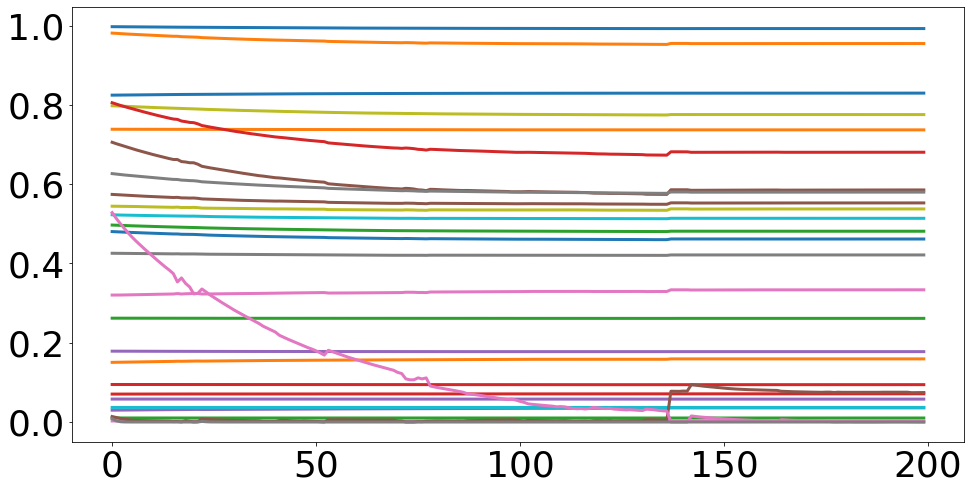

In [184]:
_ = plt.plot(List_of_h**2)

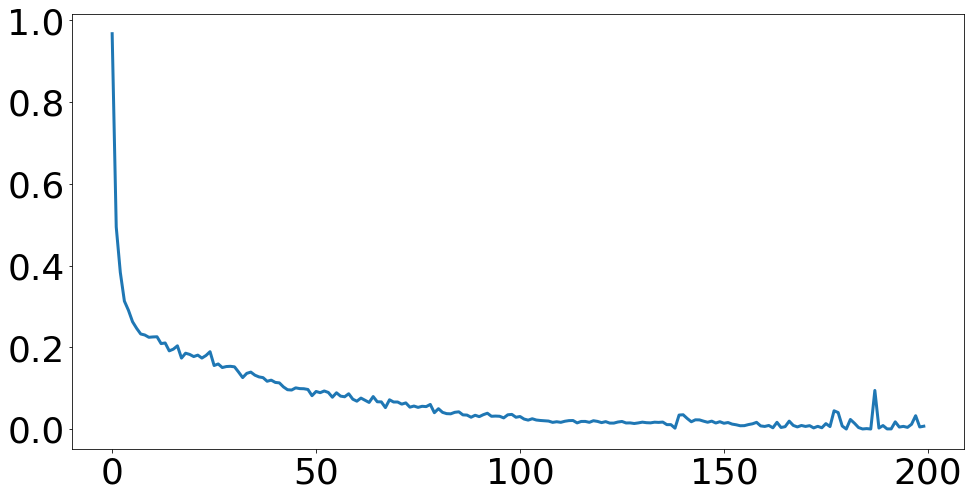

In [185]:
_ = plt.plot(List_of_loss)